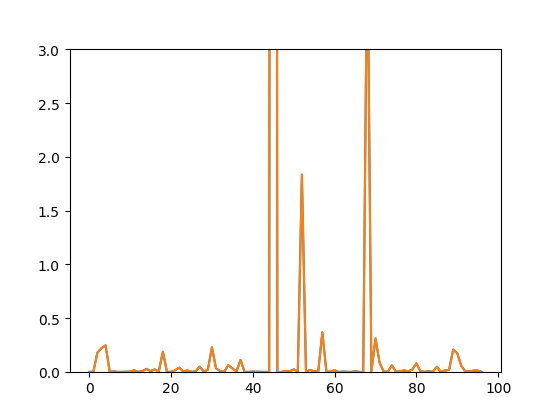

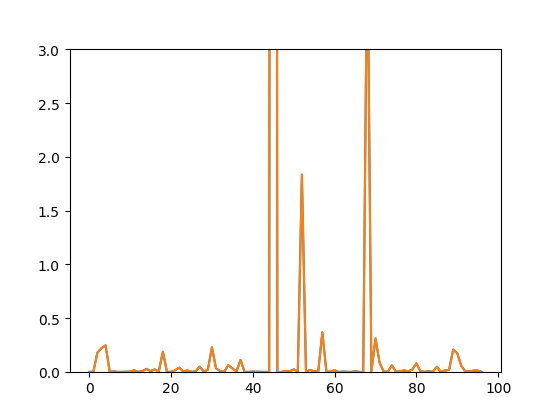

In [ ]:
import pandas as pd
import threading
import time
from IPython.display import display, clear_output
import matplotlib.pyplot as plt
import psycopg2
# Assuming app and backtest_code are already defined
class ContinuousProcessor:
    def __init__(self):
        self.index_da = None
        self.lock = threading.Lock()
        self.running = True
    def backtest_code(self, pivoted, code, rolling=10, benchmark_index='QQQ'):
        try:
            pivoted.ffill()
            ret = pivoted.pct_change(fill_method=None)
            ret['stock_price'] = pivoted[code]
            ret['index_price'] = pivoted[benchmark_index]
            ret['ret_diff'] = ret[code] - ret[benchmark_index]
            # type 2
            ret['ret_diff_std'] = ret['ret_diff'].rolling(rolling).std()
            ret['ret_diff_mean'] = ret['ret_diff'].rolling(rolling).mean()
            ret['stdize_ret_diff'] = abs((ret['ret_diff'] - ret['ret_diff_mean'])*ret['ret_diff_std'])*10000

            # # check direction
            ret['lag10'] = ret['stock_price'].shift(5)
            ret['change_stock'] = (ret['stock_price'] - ret['lag10'])/ret['lag10']
            ret['direction'] = ret.apply(lambda x: -1 if x['stock_price'] - x['lag10'] > 0 else 1, axis=1)
            
            # # check if the direction are the same, if not, tned to not being a mean reversion
            ret['lag10_twii'] = ret['index_price'].shift(5)
            ret['change_twii'] = (ret['index_price'] - ret['lag10_twii'])/ret['lag10_twii']
            ret['filter_1'] = ret.apply(lambda x: 1 if abs(x['change_stock'] - x['change_twii']) < abs(x['change_stock']) else 0, axis=1)
            ret['filter_2'] = ret.apply(lambda x: 1 if abs(x['change_stock']) < abs(x['change_twii']) else 1, axis=1)
            last = ret.iloc[-1, :]
            if last['stdize_ret_diff'] >= 2:
                print(code, last.index)
            return last['stdize_ret_diff']
        except Exception as e:
            print(e)
            return 0
    def continuous_loop(self):
        while self.running:
            try:
                clear_output(wait=True)
                DB_HOST = 'localhost'
                DB_NAME = 'us'
                DB_USER = 'postgres'
                DB_PASS = 'buddyrich134'
                
                def get_db_connection():
                    conn = psycopg2.connect(host=DB_HOST, dbname=DB_NAME, user=DB_USER, password=DB_PASS)
                    return conn
                conn = get_db_connection()
                cursor = conn.cursor()
                cursor.execute("SELECT da, code, cl from public.stock_price order by da desc limit 2000;")
                conn.commit()
                data = cursor.fetchall()
                df = pd.DataFrame(data, columns=['da', 'code', 'cl'])
                df = df.pivot(values='cl', index='da', columns='code').sort_index(ascending=True)
                df1 = df.ffill()
                print(df1.index[0], df1.index[-1])
                last_ = []
                for code in df1.columns:
                    if code == "QQQ":
                        continue
                    last_.append(self.backtest_code(df1[['QQQ', code]], code))
                plt.plot(last_)
                plt.show()
                if sum(last_) == 0:
                    time.sleep(2)
                    last_ = []
                    for code in df1.columns:
                        if code == "QQQ":
                            continue
                        last_.append(self.backtest_code(df1[['QQQ', code]], code))
                    plt.plot(last_)
                    pl.show()
                time.sleep(10)
            except Exception as e:
                print(e)
                pass
    def stop(self):
        self.running = False

processor = ContinuousProcessor()
# 
# Start the continuous loop in a separate thread
loop_thread = threading.Thread(target=processor.continuous_loop, daemon=True)
loop_thread.start()

2024-08-27 15:44:00 2024-08-27 16:04:00
IDXX Index(['QQQ', 'IDXX', 'stock_price', 'index_price', 'ret_diff', 'ret_diff_std',
       'ret_diff_mean', 'stdize_ret_diff', 'lag10', 'change_stock',
       'direction', 'lag10_twii', 'change_twii', 'filter_1', 'filter_2'],
      dtype='object', name='code')
NXPI Index(['QQQ', 'NXPI', 'stock_price', 'index_price', 'ret_diff', 'ret_diff_std',
       'ret_diff_mean', 'stdize_ret_diff', 'lag10', 'change_stock',
       'direction', 'lag10_twii', 'change_twii', 'filter_1', 'filter_2'],
      dtype='object', name='code')


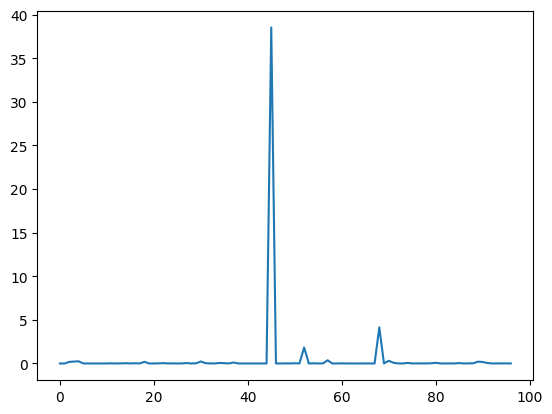

In [14]:
import pandas as pd
import threading
import time
from IPython.display import display, clear_output
import matplotlib.pyplot as plt
import psycopg2
def backtest_code(pivoted, code, rolling=10, benchmark_index='QQQ'):
    try:
        pivoted.ffill()
        ret = pivoted.pct_change(fill_method=None)
        ret['stock_price'] = pivoted[code]
        ret['index_price'] = pivoted[benchmark_index]
        ret['ret_diff'] = ret[code] - ret[benchmark_index]
        # type 2
        ret['ret_diff_std'] = ret['ret_diff'].rolling(rolling).std()
        ret['ret_diff_mean'] = ret['ret_diff'].rolling(rolling).mean()
        ret['stdize_ret_diff'] = abs((ret['ret_diff'] - ret['ret_diff_mean'])*ret['ret_diff_std'])*10000

        # # check direction
        ret['lag10'] = ret['stock_price'].shift(5)
        ret['change_stock'] = (ret['stock_price'] - ret['lag10'])/ret['lag10']
        ret['direction'] = ret.apply(lambda x: -1 if x['stock_price'] - x['lag10'] > 0 else 1, axis=1)
        
        # # check if the direction are the same, if not, tned to not being a mean reversion
        ret['lag10_twii'] = ret['index_price'].shift(5)
        ret['change_twii'] = (ret['index_price'] - ret['lag10_twii'])/ret['lag10_twii']
        ret['filter_1'] = ret.apply(lambda x: 1 if abs(x['change_stock'] - x['change_twii']) < abs(x['change_stock']) else 0, axis=1)
        ret['filter_2'] = ret.apply(lambda x: 1 if abs(x['change_stock']) < abs(x['change_twii']) else 1, axis=1)
        last = ret.iloc[-1, :]
        if last['stdize_ret_diff'] >= 2:
            print(code, last.index)
        return [last['stdize_ret_diff'], code]
    except Exception as e:
        print(e)
        return 0
DB_HOST = 'localhost'
DB_NAME = 'us'
DB_USER = 'postgres'
DB_PASS = 'buddyrich134'

def get_db_connection():
    conn = psycopg2.connect(host=DB_HOST, dbname=DB_NAME, user=DB_USER, password=DB_PASS)
    return conn
conn = get_db_connection()
cursor = conn.cursor()
cursor.execute("SELECT da, code, cl from public.stock_price order by da desc limit 2000;")
conn.commit()
data = cursor.fetchall()
df = pd.DataFrame(data, columns=['da', 'code', 'cl'])
df = df.pivot(values='cl', index='da', columns='code').sort_index(ascending=True)
df1 = df.ffill()
print(df1.index[0], df1.index[-1])
last_ = []
for code in df1.columns:
    if code == "QQQ":
        continue
    last_.append(backtest_code(df1[['QQQ', code]], code))
plt.plot([i[0] for i in last_])
plt.show()

In [16]:
dfs = []
from tqdm import tqdm
for code in tqdm(list(df1.columns)):
    if code == 'QQQ': continue
    df = backtest_code(df1[['QQQ', code]], code)
    dfs.append(df)
[i[1] for i in dfs if i[0] >= 2]

100%|██████████| 98/98 [00:00<00:00, 386.33it/s]

IDXX Index(['QQQ', 'IDXX', 'stock_price', 'index_price', 'ret_diff', 'ret_diff_std',
       'ret_diff_mean', 'stdize_ret_diff', 'lag10', 'change_stock',
       'direction', 'lag10_twii', 'change_twii', 'filter_1', 'filter_2'],
      dtype='object', name='code')
NXPI Index(['QQQ', 'NXPI', 'stock_price', 'index_price', 'ret_diff', 'ret_diff_std',
       'ret_diff_mean', 'stdize_ret_diff', 'lag10', 'change_stock',
       'direction', 'lag10_twii', 'change_twii', 'filter_1', 'filter_2'],
      dtype='object', name='code')


['IDXX', 'NXPI']